# Criando um modelo para prever a qualidade dos vinhos


#### O problema
O presente problema se refere aos dados de vinhos portugueses "Vinho Verde", que possuem
variantes de vinho branco e tinto. Devido a questões de privacidade, apenas variáveis
físico-químicas (input) e sensoriais (output) estão disponíveis (por exemplo, não há dados
sobre tipo de uva, marca do vinho, preço de venda, etc).

#### Objetivo
Criar um modelo para estimar a qualidade do vinho.
Informação sobre os atributos
Variáveis input (baseado em testes físico-químicos):
1. Tipo
2. Acidez fixa
3. Volatilidade da acidez
4. Ácido cítrico
5. Açúcar residual
6. Cloretos
7. Dióxido de enxofre livre
8. Dióxido de enxofre total
9. Densidade
10. pH
11. Sulfatos
12. Álcool

#### Variável output/target (baseado em dado sensorial):
Qualidade (score entre 0 and 10)


### Resolução
1. Faça uma análise exploratória para avaliar a consistência dos dados e identificar
possíveis variáveis que impactam na qualidade do vinho.

2. Para a realização deste teste você pode utilizar o software de sua preferência (Python
ou R), só pedimos que compartilhe conosco o código fonte (utilizando um repositório git). Além disso, inclua um arquivo README.md onde você deve cobrir as respostasn para os 5 pontos abaixo:

    a. Como foi a definição da sua estratégia de modelagem?
    
    b. Como foi definida a função de custo utilizada?
    
    c. Qual foi o critério utilizado na seleção do modelo final?
    
    d. Qual foi o critério utilizado para validação do modelo? Por que escolheu utilizar
    este método?
    
    e. Quais evidências você possui de que seu modelo é suficientemente bom?
    

# Importando os pacotes que serão usados

In [1]:
%matplotlib inline
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from io import StringIO
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import export_graphviz
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from datetime import datetime
import shap

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from mlens.ensemble import SuperLearner


import pydotplus
from IPython.display import Image
from xgboost import XGBRegressor


from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")


if not sys.warnoptions:
    warnings.simplefilter("ignore")

    
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 12, 8

%matplotlib inline
pd.options.display.max_columns = 75
%config InlineBackend.figure_format = 'retina'
pd.options.display.float_format = '{:.2f}'.format


import ipywidgets as widgets
from IPython.display import display, HTML

javascript_functions = {False: "hide()", True: "show()"}
button_descriptions  = {False: "Show code", True: "Hide code"}

def toggle_code(state):

    """
    Toggles the JavaScript show()/hide() function on the div.input element.
    """

    output_string = "<script>$(\"div.input\").{}</script>"
    output_args   = (javascript_functions[state],)
    output        = output_string.format(*output_args)

    display(HTML(output))


def button_action(value):

    """
    Calls the toggle_code function and updates the button description.
    """

    state = value.new

    toggle_code(state)

    value.owner.description = button_descriptions[state]


state = False
toggle_code(state)

button = widgets.ToggleButton(state, description = button_descriptions[state])
button.observe(button_action, "value")

display(button)

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

Using TensorFlow backend.
C:\Users\marcos\Anaconda3\lib\site-packages\shap\explainers\deep.py:21: UserWarning: Your Keras version is older than 2.2.0 and not supported.
  warnings.warn("Your Keras version is older than 2.2.0 and not supported.")
[MLENS] backend: threading


ToggleButton(value=False, description='Show code')

# Importando os dados

In [3]:
wine=pd.read_csv("winequality.csv",sep=';')
wine.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  White           7.00              0.27         0.36           20.70   
1  White           6.30              0.30         0.34            1.60   
2  White           8.10              0.28         0.40            6.90   
3  White           7.20              0.23         0.32            8.50   
4  White           7.20              0.23         0.32            8.50   

   chlorides  free sulfur dioxide  total sulfur dioxide  density   pH  \
0       0.04                45.00                170.00     1.00 3.00   
1       0.05                14.00                132.00     0.99 3.30   
2       0.05                30.00                 97.00     1.00 3.26   
3       0.06                47.00                186.00     1.00 3.19   
4       0.06                47.00                186.00     1.00 3.19   

   sulphates  alcohol  quality  
0       0.45     8.80        6  
1       0.49     9.50        6  
2       0.44    10.10        6  
3       0.40     9.90        6  
4       0.40     9.90        6

In [4]:
wine.dtypes

type                     object
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

# Análise exploratória dos dados

In [5]:
# Havia alguns problemas com a variável alcohol que foram tratados com comandos semelhantes a esse:
wine[wine.alcohol==97.333000]['alcohol']=9.7333000

# esse tipo de problema é bastante comum ao transformar variáveis numéricas e há muitas formas de lidar
# com esse tipo de problema, como a quantidade era muito pequena, faz mais sentido arrumar manualmente.

In [6]:
# O primeiro overview nos dados fazemos com o comando describe do pandas 
# que retorna um resumo para as variáveis numéricas
wine.describe().T

count   mean   std  min   25%    50%    75%    max
fixed acidity        6497.00   7.22  1.30 3.80  6.40   7.00   7.70  15.90
volatile acidity     6497.00   0.34  0.16 0.08  0.23   0.29   0.40   1.58
citric acid          6497.00   0.32  0.15 0.00  0.25   0.31   0.39   1.66
residual sugar       6497.00   5.44  4.76 0.60  1.80   3.00   8.10  65.80
chlorides            6497.00   0.06  0.04 0.01  0.04   0.05   0.07   0.61
free sulfur dioxide  6497.00  30.53 17.75 1.00 17.00  29.00  41.00 289.00
total sulfur dioxide 6497.00 115.74 56.52 6.00 77.00 118.00 156.00 440.00
density              6497.00   1.71  7.64 0.99  0.99   0.99   1.00 103.90
pH                   6497.00   3.22  0.16 2.72  3.11   3.21   3.32   4.01
sulphates            6497.00   0.53  0.15 0.22  0.43   0.51   0.60   2.00
alcohol              6497.00  10.57  2.86 8.00  9.50  10.30  11.30  97.33
quality              6497.00   5.82  0.87 3.00  5.00   6.00   6.00   9.00

In [7]:
# Para ficar mais fácil de "chamar" as variáveis no código, vamos remover os espaços e substituir por "_"
wine.rename(columns={'fixed acidity': 'fixed_acidity',
                     'citric acid':'citric_acid',
                     'volatile acidity':'volatile_acidity',
                     'residual sugar':'residual_sugar',
                     'free sulfur dioxide':'free_sulfur_dioxide',
                     'total sulfur dioxide':'total_sulfur_dioxide'}, inplace=True)

In [8]:
# A única variável não numérica é o type que retorna se o vinho é branco ou tinto
wine['type'].value_counts()

White    4898
Red      1599
Name: type, dtype: int64

In [9]:
wine.shape

(6497, 13)

In [10]:
wine.drop_duplicates().shape

(5321, 13)

In [11]:
# Checa a qunt
wine.isnull().sum()

type                    0
fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

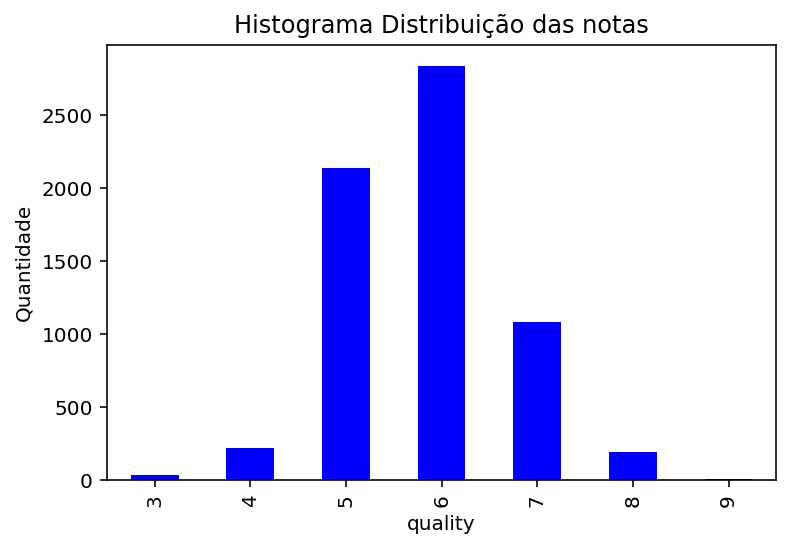

In [12]:
# Aparentemente os vinhos da base não usam todo o espectro de ratings possiveis. 
red_counts=wine.groupby('quality').size()
plt.xlabel("Qualidade")
plt.ylabel("Quantidade")
plt.title('Histograma Distribuição das notas')
red_counts.plot(kind='bar', color='b')
plt.show()

In [13]:
# Além disso, parece que as médias entre os diferentes tipos de vinhos são um pouco diferente
print("white mean = ", wine[wine['type']=='Red']["quality"].mean())         
print("red mean =", wine[wine['type']=='White']["quality"].mean())

white mean =  5.6360225140712945
red mean = 5.87790935075541


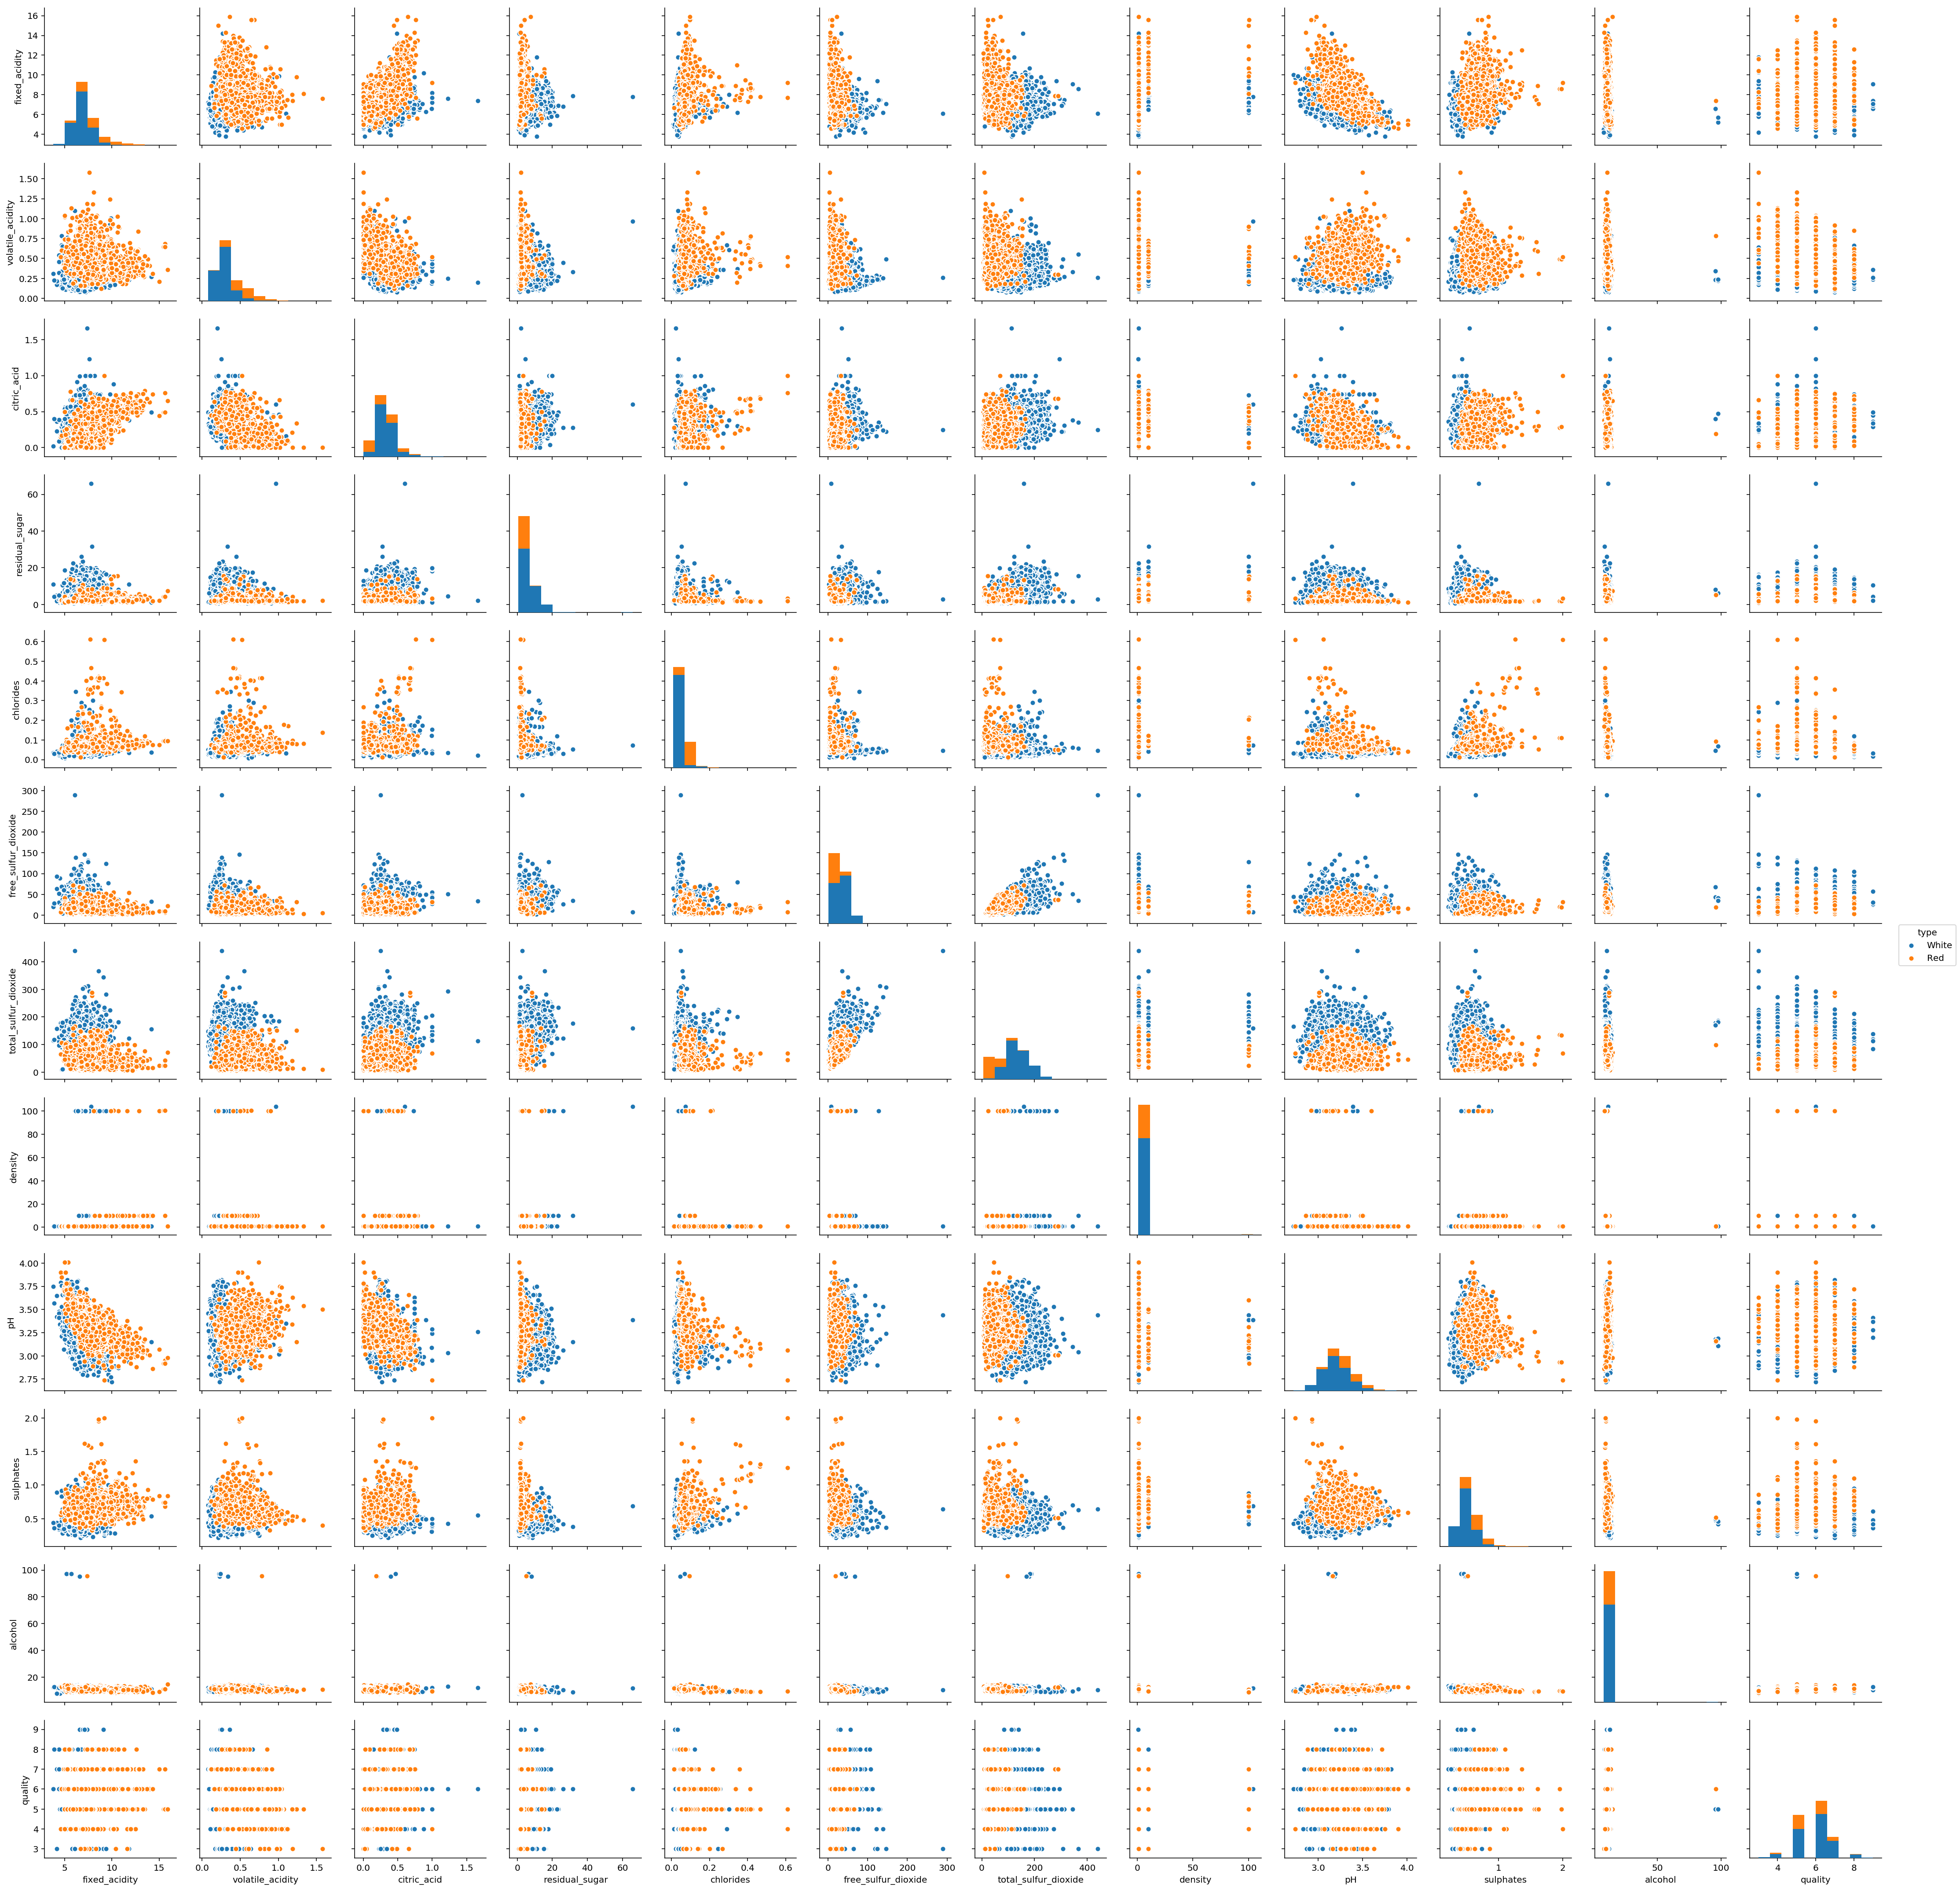

In [14]:
# Vamos tentar entender se os vinhos são diferentes para cada umas das variáveis utilizando pairplot:
sns.pairplot(wine.drop_duplicates(), hue='type')

In [15]:
# Aparentemente os tipos de vinho fazem bastante diferença para a maioria das variáveis.

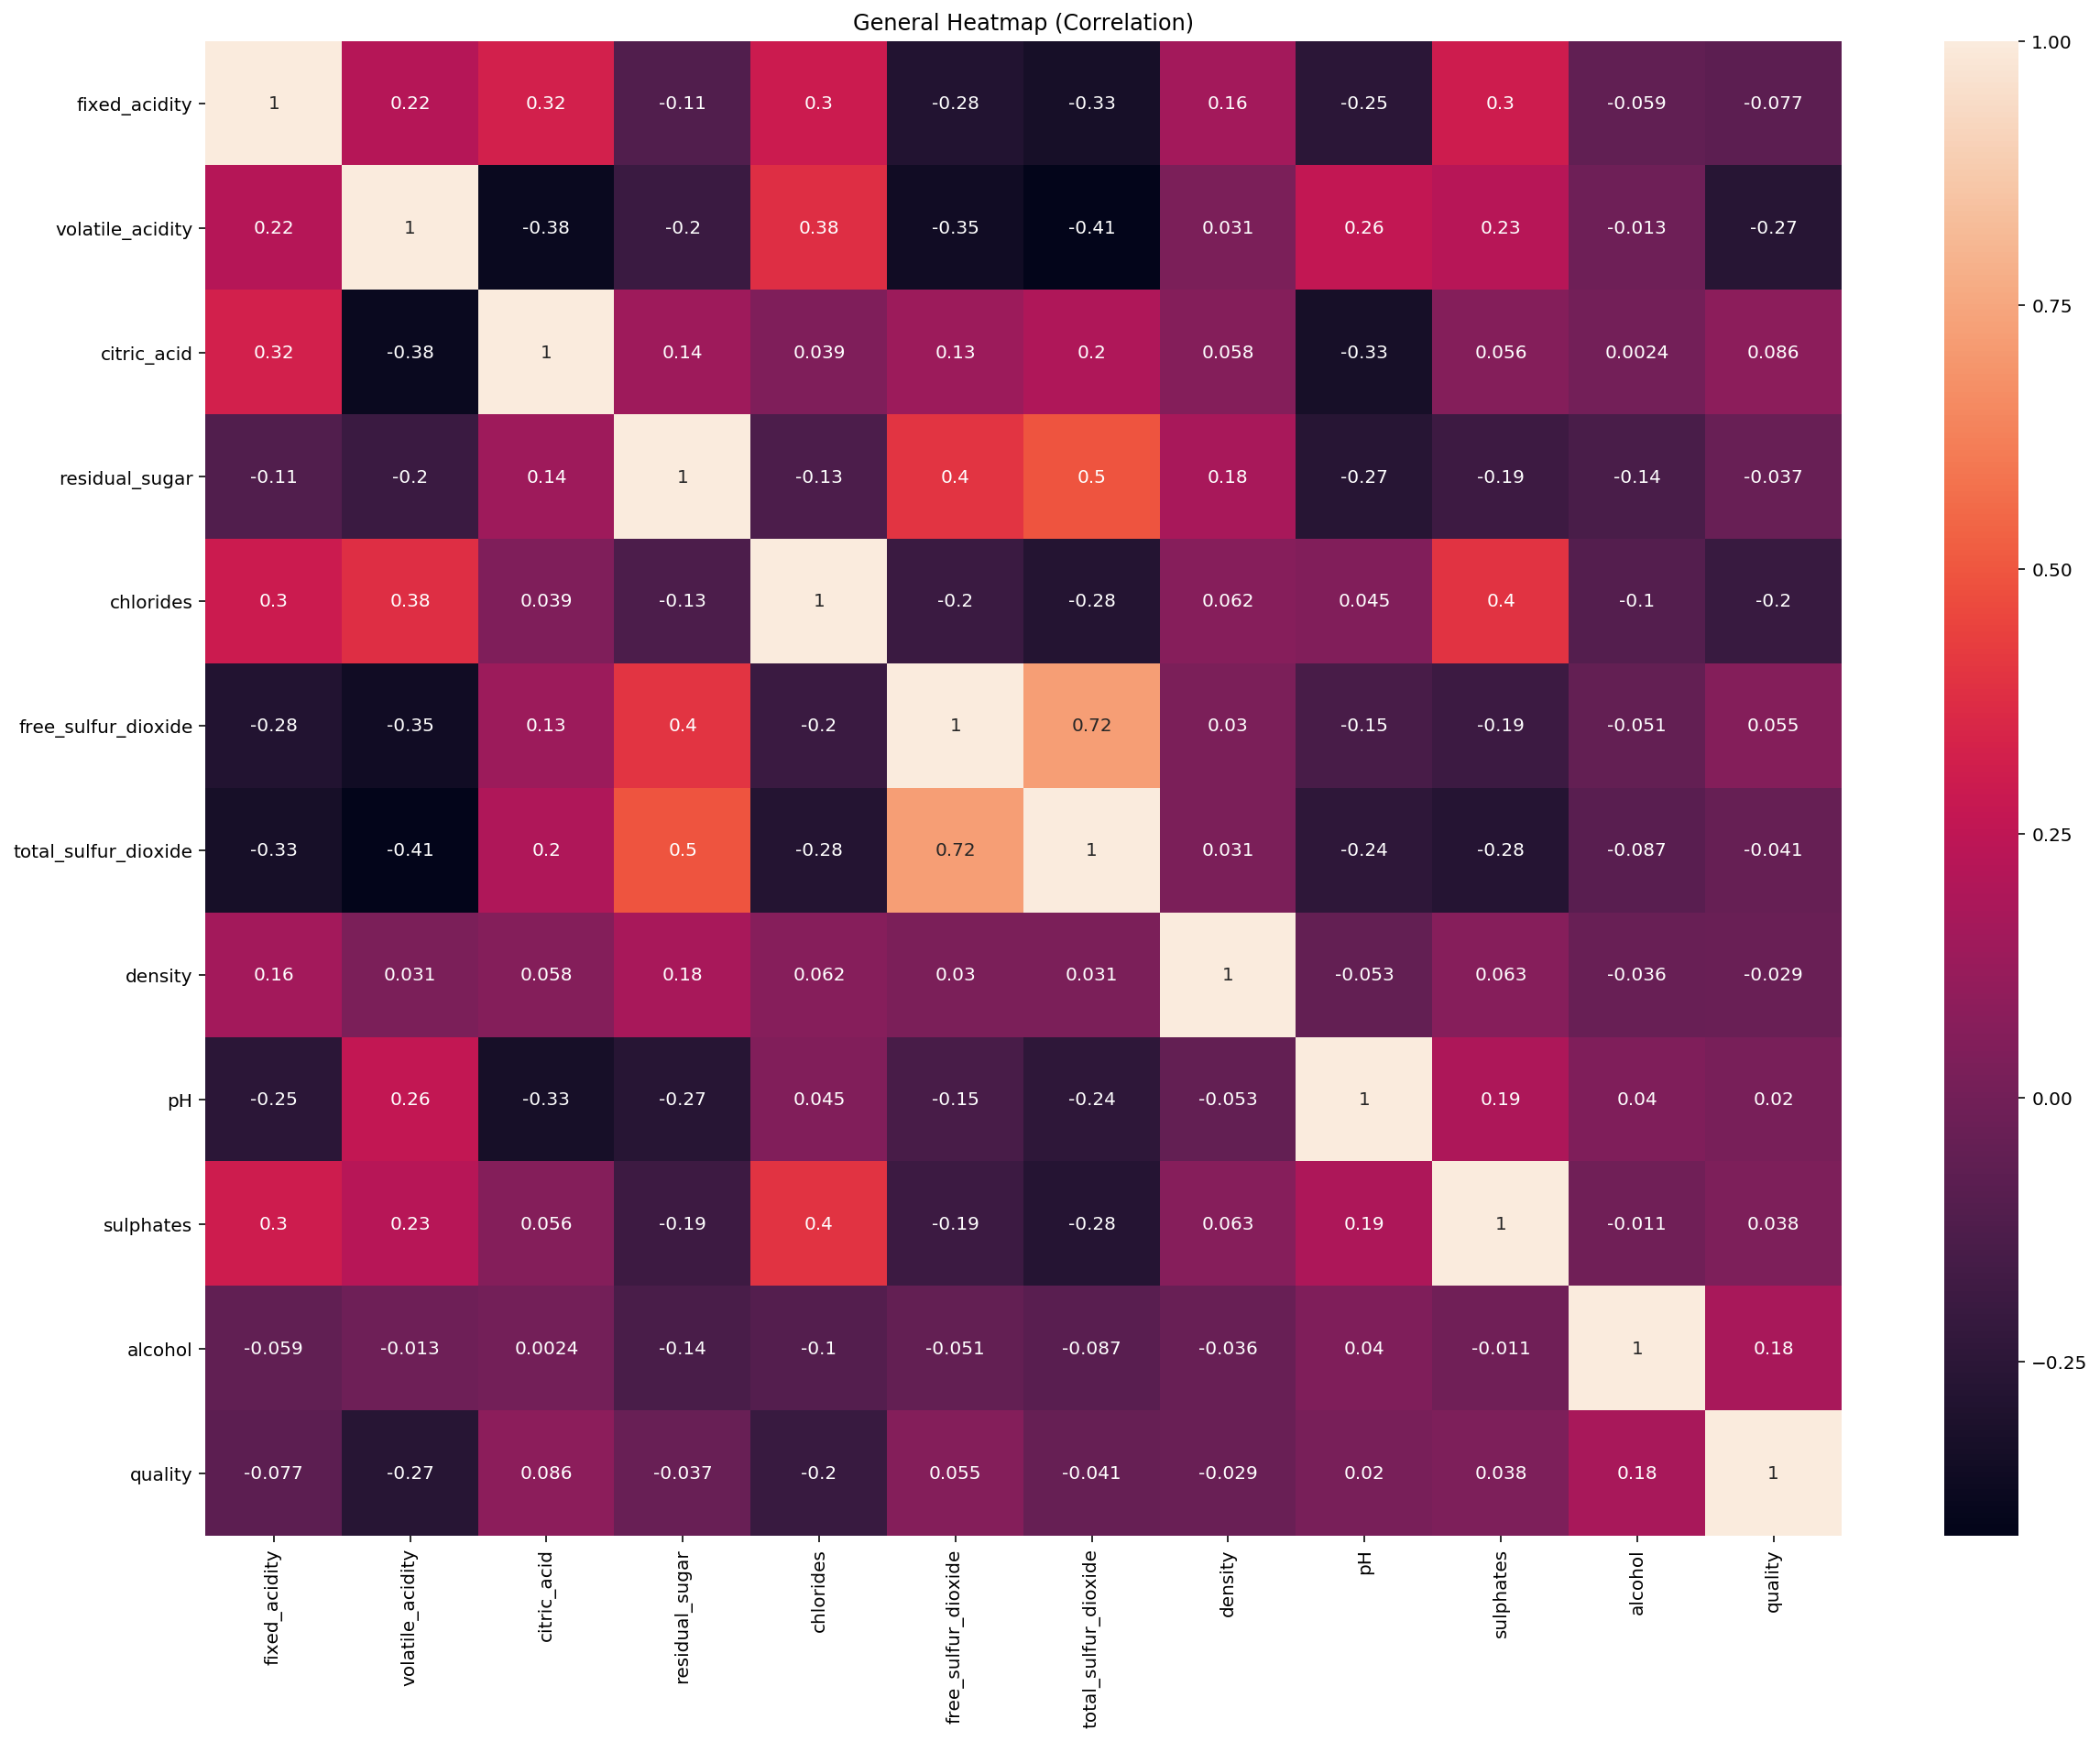

In [16]:
# Utilizando um heatmap com os valores de correlação podemos tentar entender se existem variáveis
# que são muito correlacionadas umas com as outras como o sulfur dioxide free e total (que faz sentido)
plt.subplots(figsize=(20,15))
ax = plt.axes()
ax.set_title("General Heatmap (Correlation)")
corr = wine.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           annot=True)
plt.show()

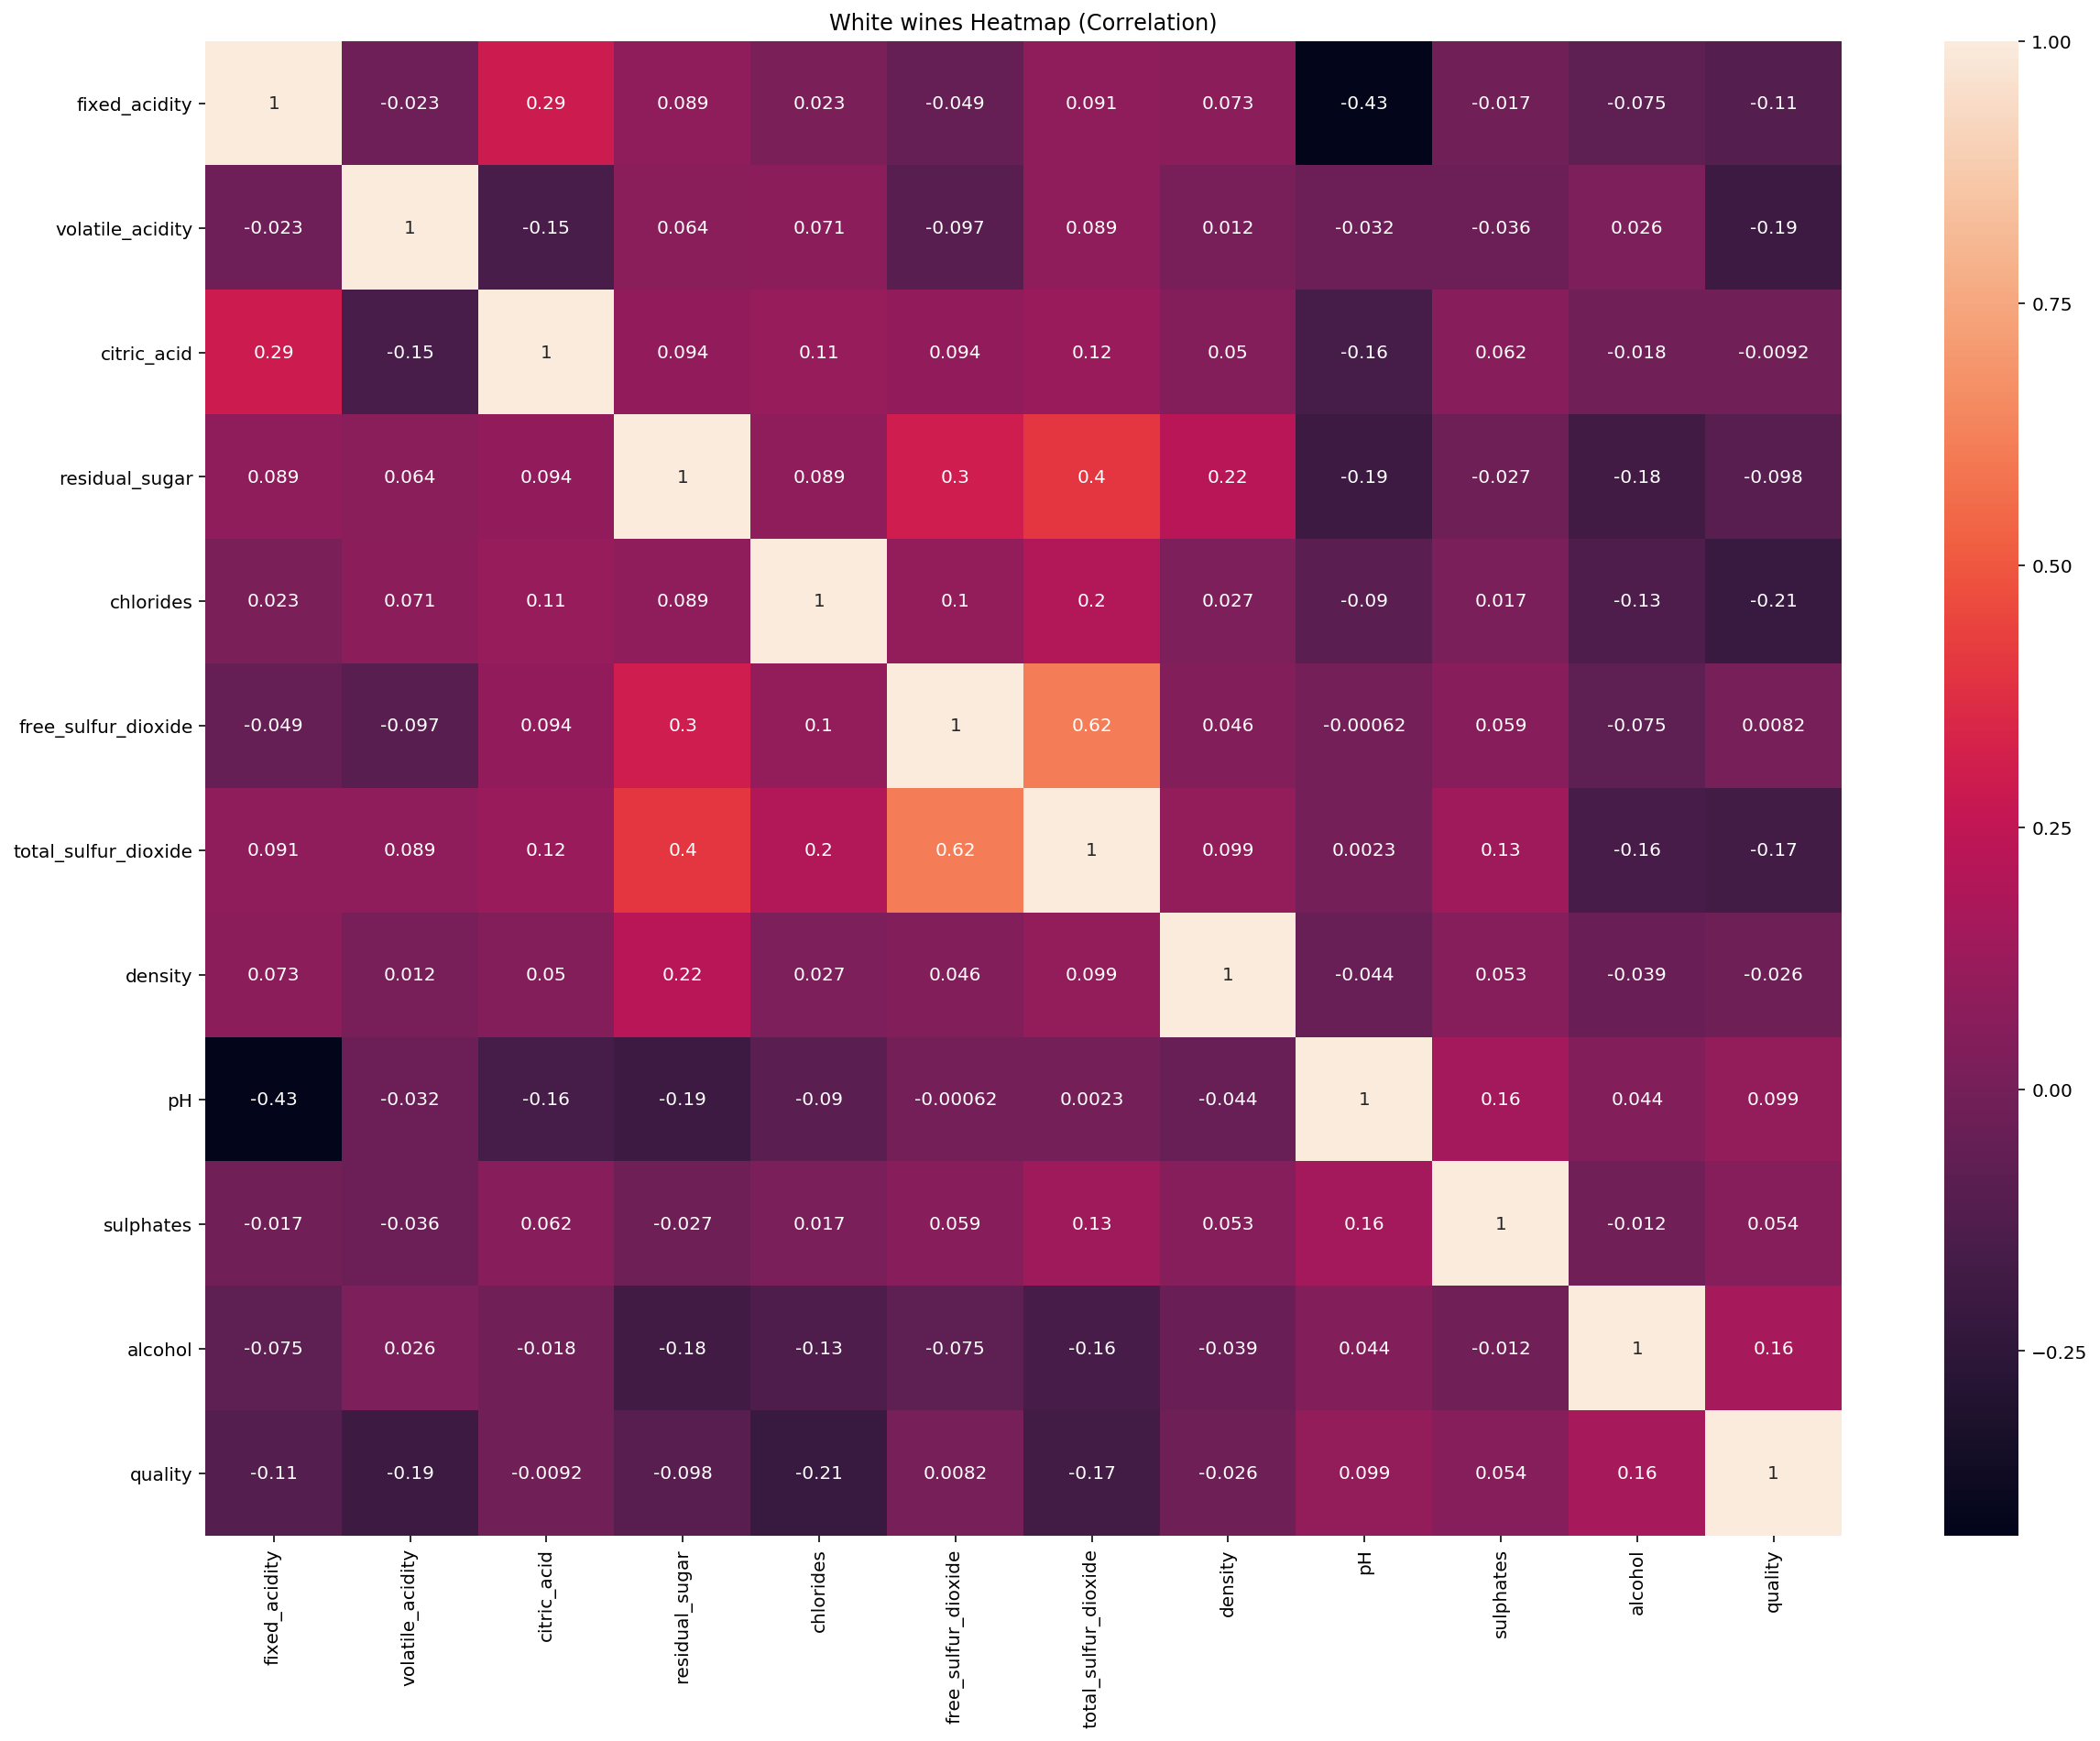

In [17]:
# Uma possível tentativa de analisar a diferença entre os vinhos branco e tinto é ver se as correlações
# lineares entre as variáveis são parecidas, para isso vamos rodar a correlação com cada um dos dois tipos:
plt.subplots(figsize=(20,15))
ax = plt.axes()
ax.set_title("White wines Heatmap (Correlation)")
corr1 = wine[wine['type']=='White'].corr()
sns.heatmap(corr1, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           annot=True)
plt.show()

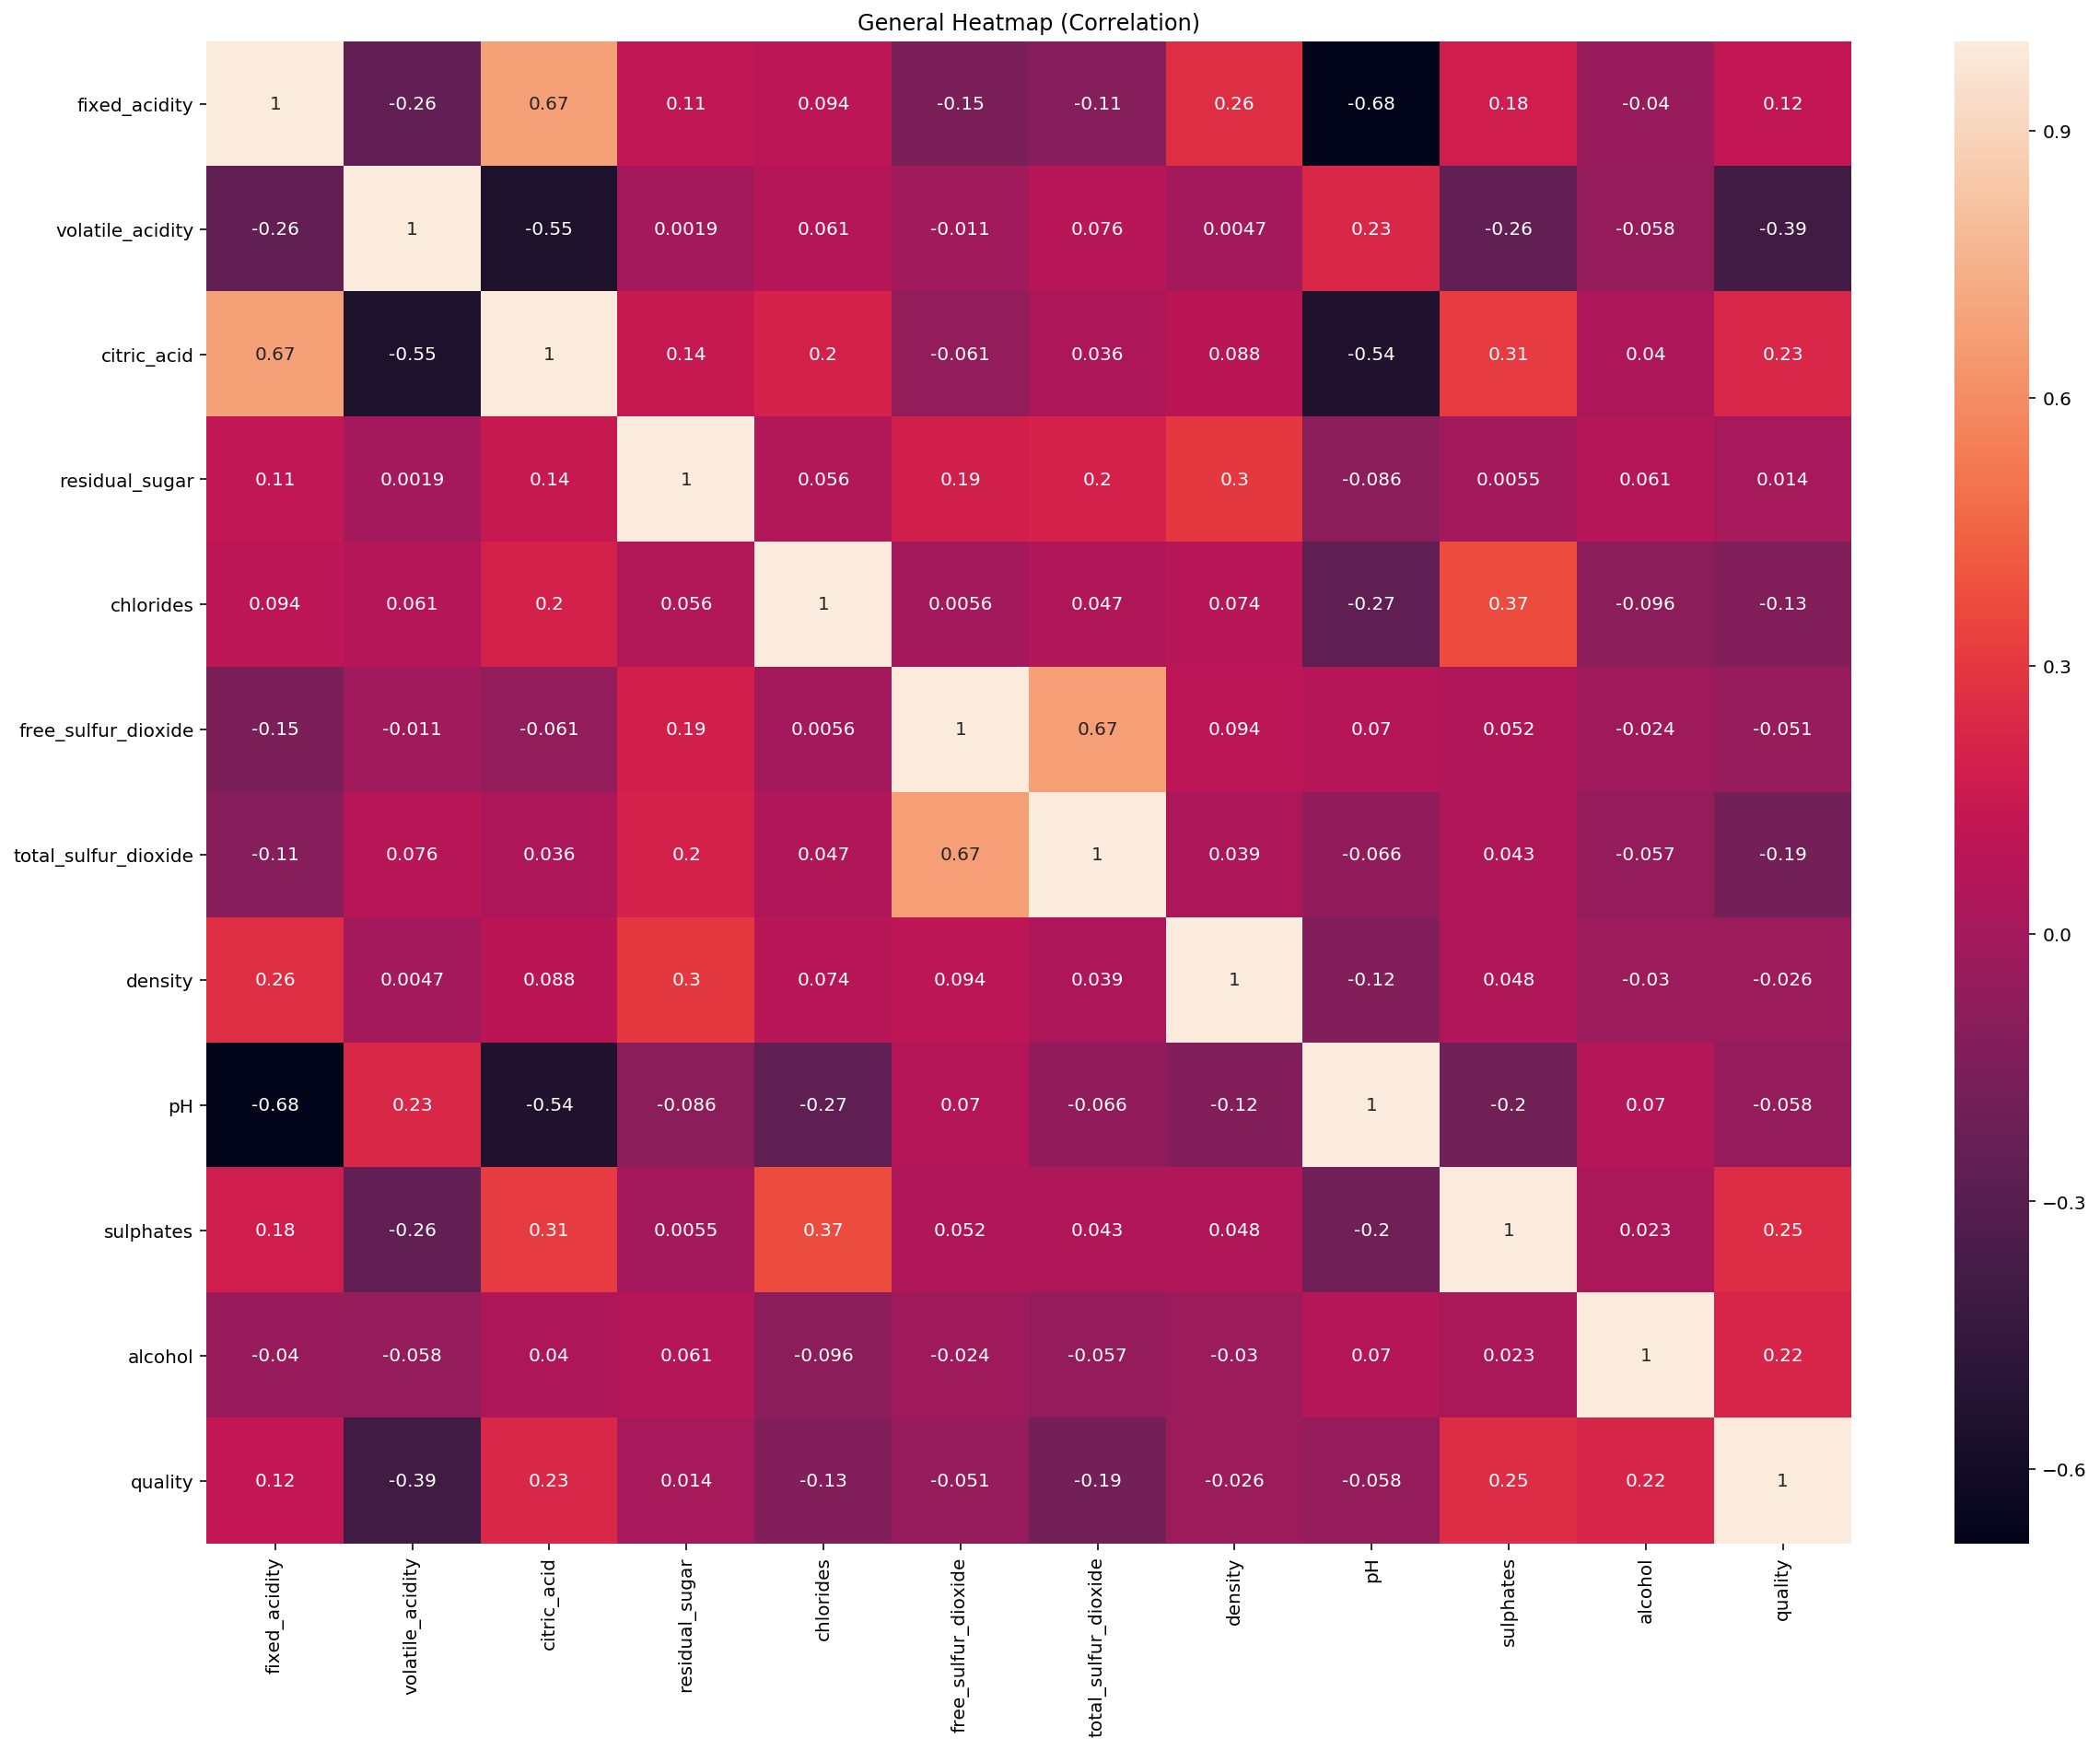

In [18]:
# Quando comparamos com os vinhos tintos vemos correlações bem diferentes, dando indicios de que deveriamos
# usar dois modelos distintos para prever cada um deles, ou, usar algum modelo que seja robusto a essa
# caracteristica dos dados, como modelos de arvores.
plt.subplots(figsize=(20,15))
ax = plt.axes()
ax.set_title("General Heatmap (Correlation)")
corr2 = wine[wine['type']=='Red'].corr()
sns.heatmap(corr2, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           annot=True)
plt.show()

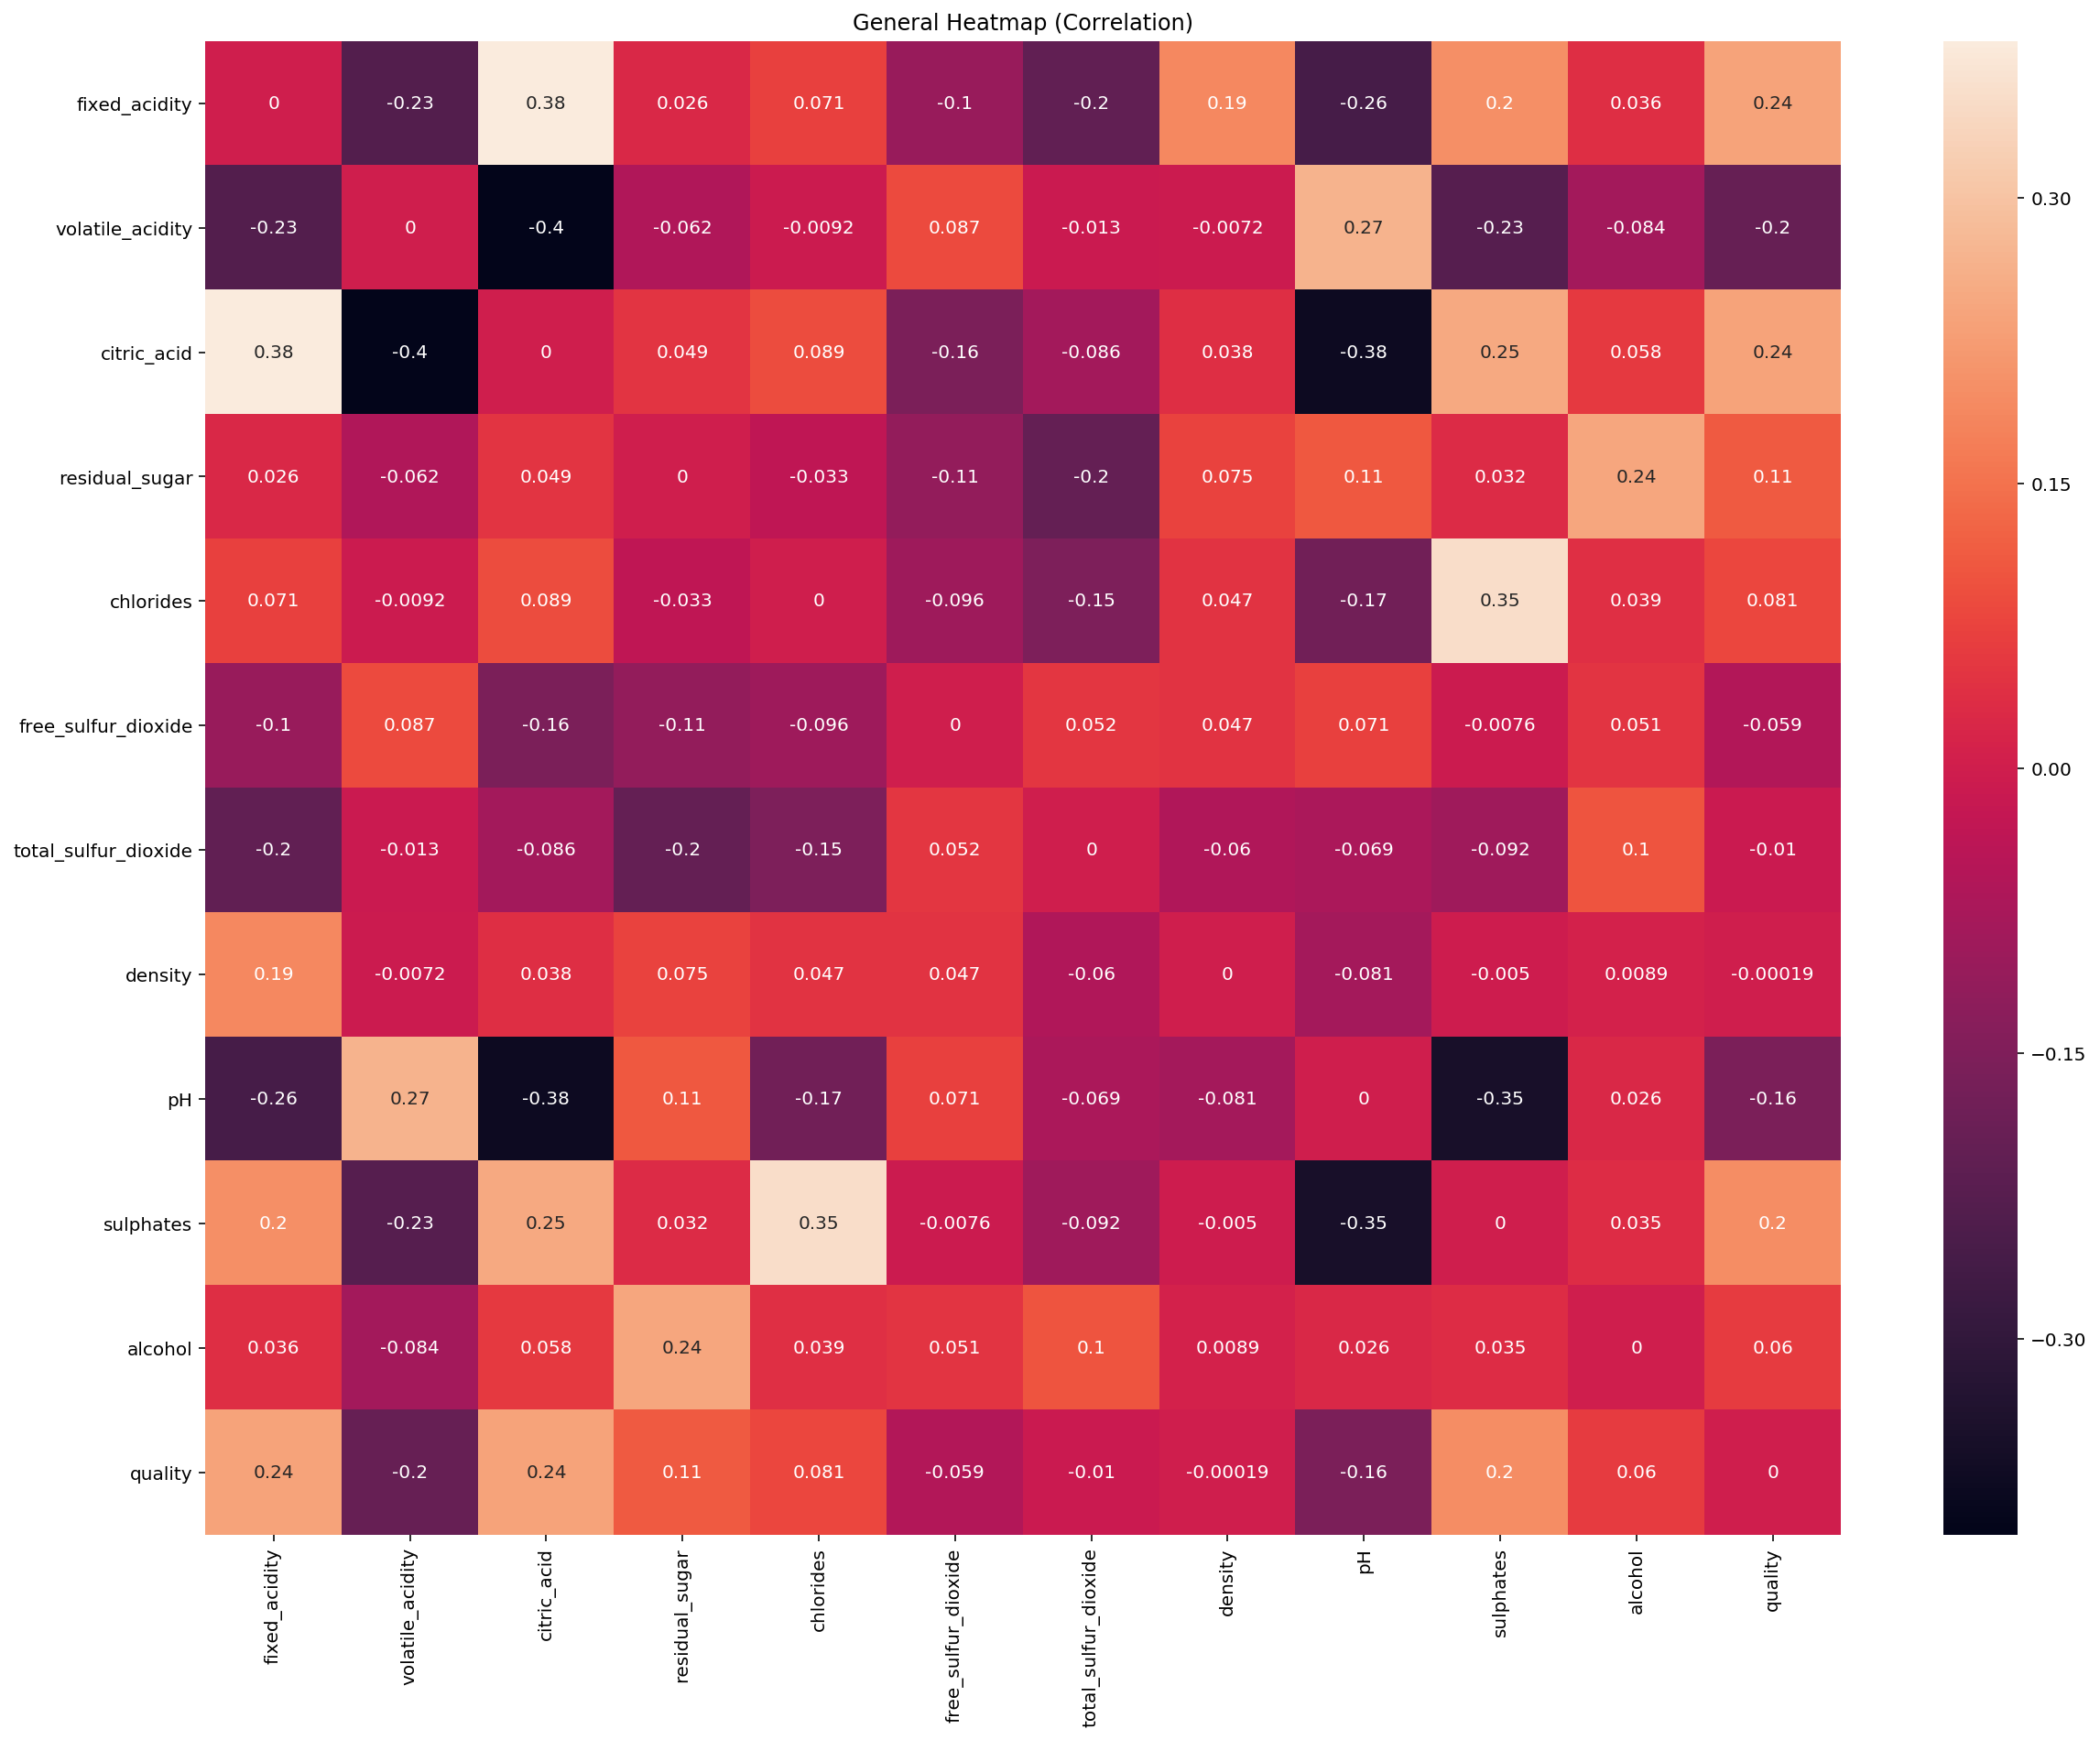

In [19]:
# Aqui podemos ver a subtração das duas correlações e o quanto as diferenças podem ser grandes
# reforçando a ideia de que, ao usar modelos lineares, possivelmente dois modelos distintos faria
# mais sentido.
plt.subplots(figsize=(20,15))
ax = plt.axes()
ax.set_title("General Heatmap (Correlation)")
sns.heatmap(corr2-corr1, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           annot=True)
plt.show()

In [20]:
# A primeira análise mais simples que faremos é rodar uma regressão linear simples
# Com  isso podemos tirar insights dos dados e entender de forma próxima a ideia de causalidade
# como a variação das variáveis afetam nossa variável target (quality)


# por exemplo podemos dizer que density não explica de forma linear a qualidade pois seu beta é muito pequeno
# e que as variáveis volatile_acidity e chlorides diminuem significamente a qualidade para pequenas variações
# em suas unidades.

# por outro lado sulphates, alcohol e citric_acid fazem a qualidade aumentar quando suas variações são positivas
function1 = '''
quality ~ total_sulfur_dioxide
+ free_sulfur_dioxide 
+ residual_sugar 
+ fixed_acidity 
+ volatile_acidity 
+ alcohol 
+ citric_acid 
+ sulphates
+ chlorides
+ pH 
+ density
+ C(type)
'''

results1 = smf.ols(function1, data=wine).fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     105.7
Date:                Sat, 01 Dec 2018   Prob (F-statistic):          9.05e-241
Time:                        22:16:07   Log-Likelihood:                -7757.3
No. Observations:                6497   AIC:                         1.554e+04
Df Residuals:                    6484   BIC:                         1.563e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                5.2973 

In [21]:
# Podemos tentar normalizar algumas variáveis muito assimétricas para que modelos lineares consigam
# capturar melhor os efeitos já que esperam correlações lineares.
numeric_feats = wine.dtypes[wine.dtypes != "object"].index
skewed_feats = wine[numeric_feats].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(20)


Skew in numerical features: 



Skew
alcohol              24.71
density              12.58
chlorides             5.40
sulphates             1.80
fixed_acidity         1.72
volatile_acidity      1.49
residual_sugar        1.44
free_sulfur_dioxide   1.22
citric_acid           0.47
pH                    0.39
quality               0.19
total_sulfur_dioxide -0.00

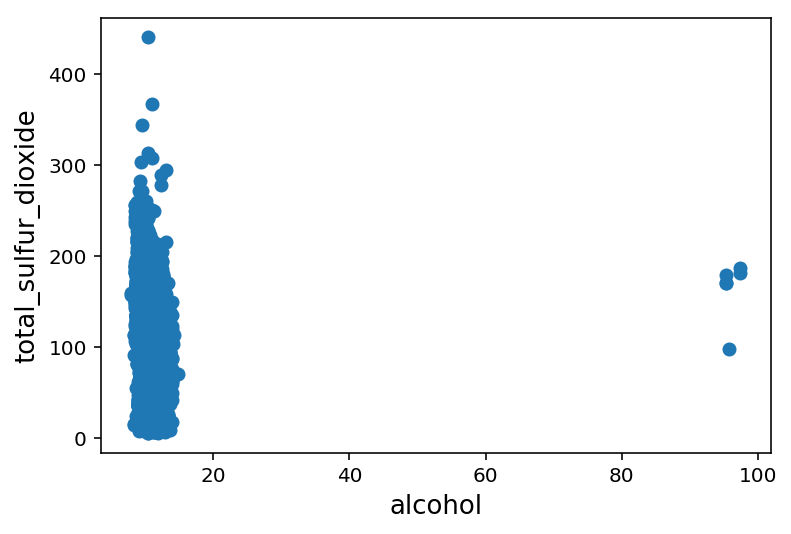

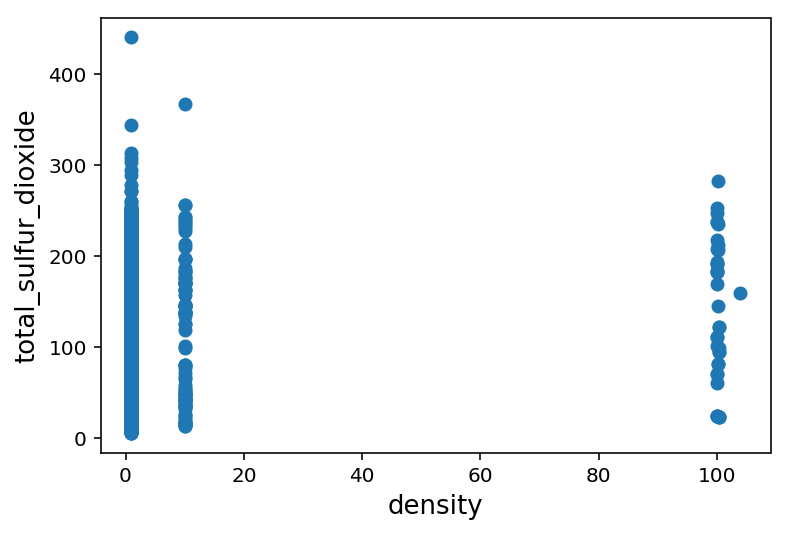

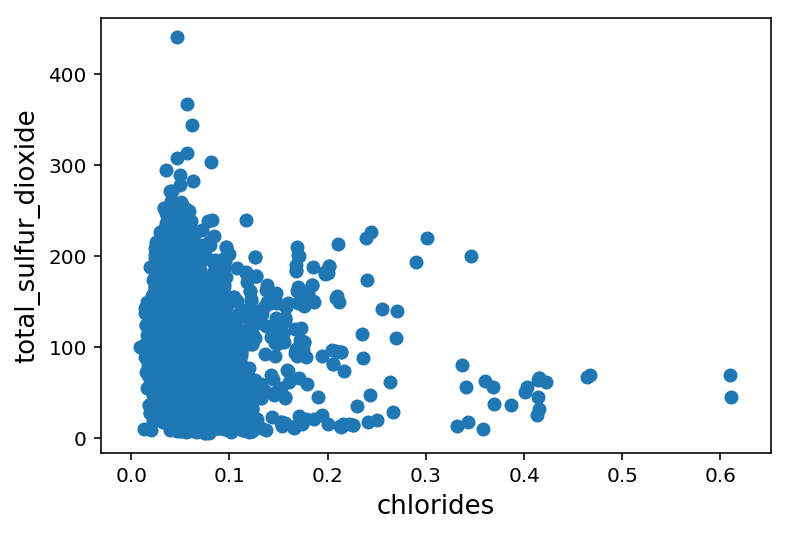

In [22]:
for assimetric_column in skewness[skewness['Skew']>2].index:    
    fig, ax = plt.subplots()
    ax.scatter(x = wine[assimetric_column], y = wine['total_sulfur_dioxide'])
    plt.ylabel('total_sulfur_dioxide', fontsize=13)
    plt.xlabel(assimetric_column, fontsize=13)
    plt.show()

In [23]:
def fix_alcohol_values(row):
    new_value = 0
    if row['alcohol']>20:
        new_value = row['alcohol']/10
    else:
        new_value = row['alcohol']
    return new_value

wine['alcohol'] = wine.apply(fix_alcohol_values, axis=1)

wine[wine['alcohol']>20]

Empty DataFrame
Columns: [type, fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, pH, sulphates, alcohol, quality]
Index: []

In [24]:
def fix_density_values(row):
    new_value = 0
    if row['density']>2 and row['density']< 20:
        new_value = row['density']/10
    elif row['density']>20:
        new_value = row['density']/100
    else:
        new_value = row['density']
    return new_value

wine['density'] = wine.apply(fix_density_values, axis=1)

wine[wine['density']>2]

Empty DataFrame
Columns: [type, fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, pH, sulphates, alcohol, quality]
Index: []

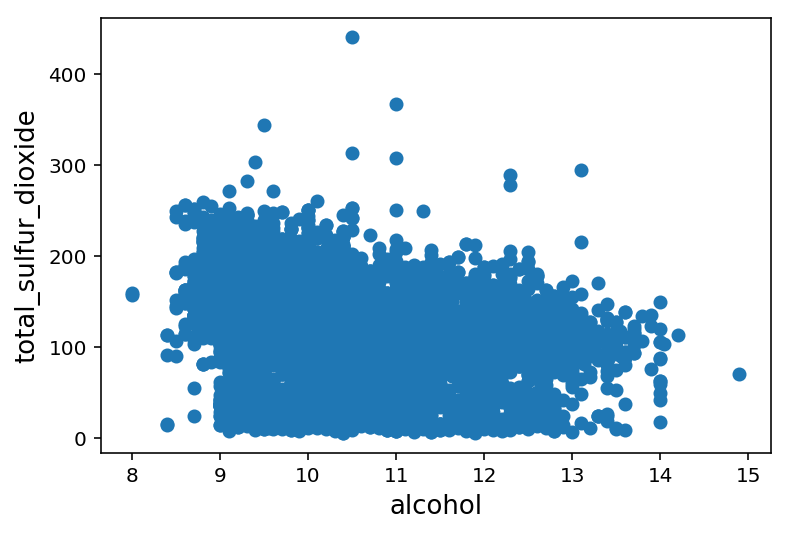

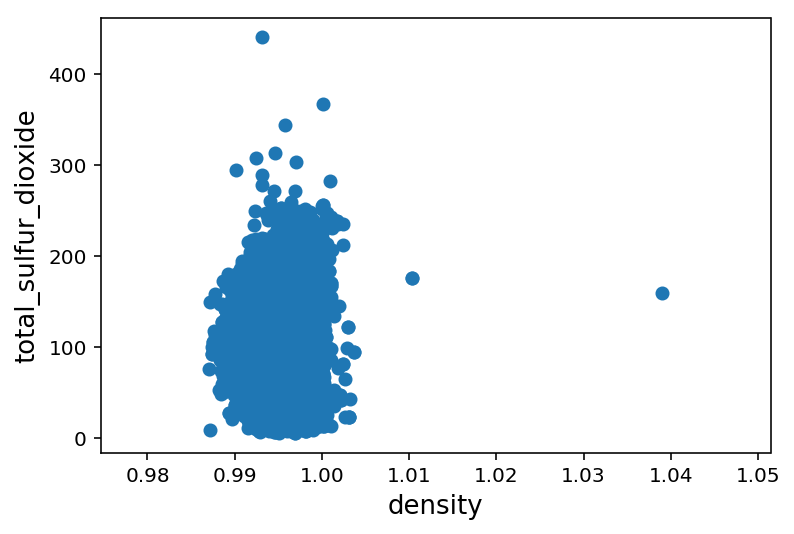

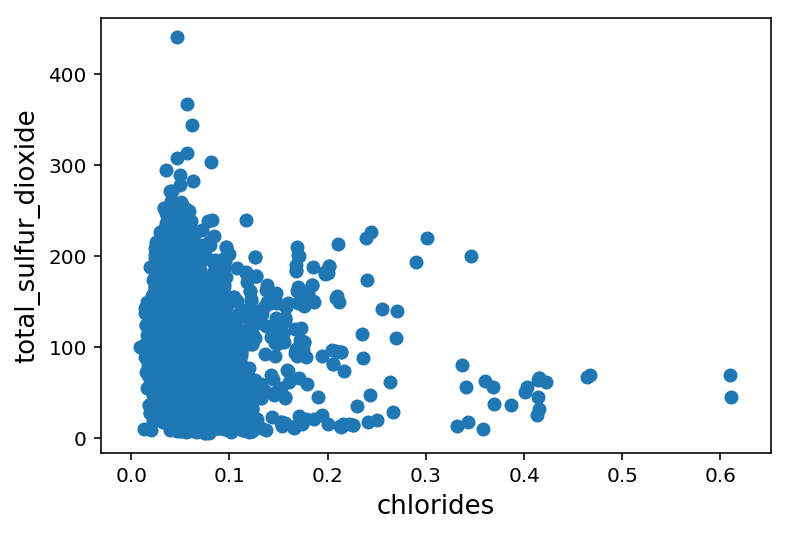

In [25]:
for assimetric_column in skewness[skewness['Skew']>2].index:    
    fig, ax = plt.subplots()
    ax.scatter(x = wine[assimetric_column], y = wine['total_sulfur_dioxide'])
    plt.ylabel('total_sulfur_dioxide', fontsize=13)
    plt.xlabel(assimetric_column, fontsize=13)
    plt.show()

In [26]:
# Depos de ter feito alguns ajustes, vamos rodar o mesmo modelo linear simples
# e aumentamos nosso R2 para quase o dobro !!
function1 = '''
quality ~ total_sulfur_dioxide
+ free_sulfur_dioxide 
+ residual_sugar 
+ fixed_acidity 
+ volatile_acidity 
+ alcohol 
+ citric_acid 
+ sulphates
+ chlorides
+ pH 
+ density
+ C(type)
'''

results1 = smf.ols(function1, data=wine).fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     227.8
Date:                Sat, 01 Dec 2018   Prob (F-statistic):               0.00
Time:                        22:16:10   Log-Likelihood:                -7195.2
No. Observations:                6497   AIC:                         1.442e+04
Df Residuals:                    6484   BIC:                         1.450e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              104.7480 

# Inicio dos modelos preditivos

In [27]:
# Nosso primeiro passo é criar as dummies de forma explicita 
# já que o statsmodel fazia isso automaticamente
wine_w_dummies = pd.get_dummies(wine)

# Separar nossos dados em variáveis explicativas
X = wine_w_dummies.drop('quality', axis=1)
# E variável target
y = wine_w_dummies['quality']

# E por último splitar nossos dados em treino e teste de forma simples por hora.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [28]:
# O primeiro modelo que vamos rodar é uma arvore de decisão.
# E escolhe-se esse tipo de modelo porque ele:
# 1) Consegue capturar efeitos não lineares e 
# 2) Dá como output um arvore de decisão que realmente conseguimos interpretar e ver se faz sentido.
# seu ponto fraco é basicamente o possível overfiting, mas usaremos algumas podas para minimizar isso.
dtr = DecisionTreeRegressor(max_depth=3)
dtr.fit(X_train,y_train)
yhat = dtr.predict(X_test)
r2 = metrics.r2_score(y_test,yhat)
mse = metrics.mean_squared_error(y_test,yhat)

print(f'r2: {round(r2,4)}, mse:{round(mse,4)}')

r2: 0.2402, mse:0.5577


In [ ]:
# Vamos tentar escolher a profundidade certa da arvore de forma interativa:
def run_decision_tree(depth=1):
    dtr = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=3)
    return -cross_val_score(dtr,X, y,scoring='neg_mean_squared_error', cv=10)

# Vamos rodar de 1 até 10 niveis de profundidade com crossvalidate
list_metrics=[]
for i in range(1,20,1):
    row=[]
    score = run_decision_tree(i)
    row.append(i)
    row.append(score.mean())
    list_metrics.append(row)
    
# olhando as métricas, parece que o melhor nível de profundidade é o 5
pd.DataFrame(list_metrics, columns=['depth','score'])

In [30]:
dtr = DecisionTreeRegressor(max_depth=5)
dtr.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

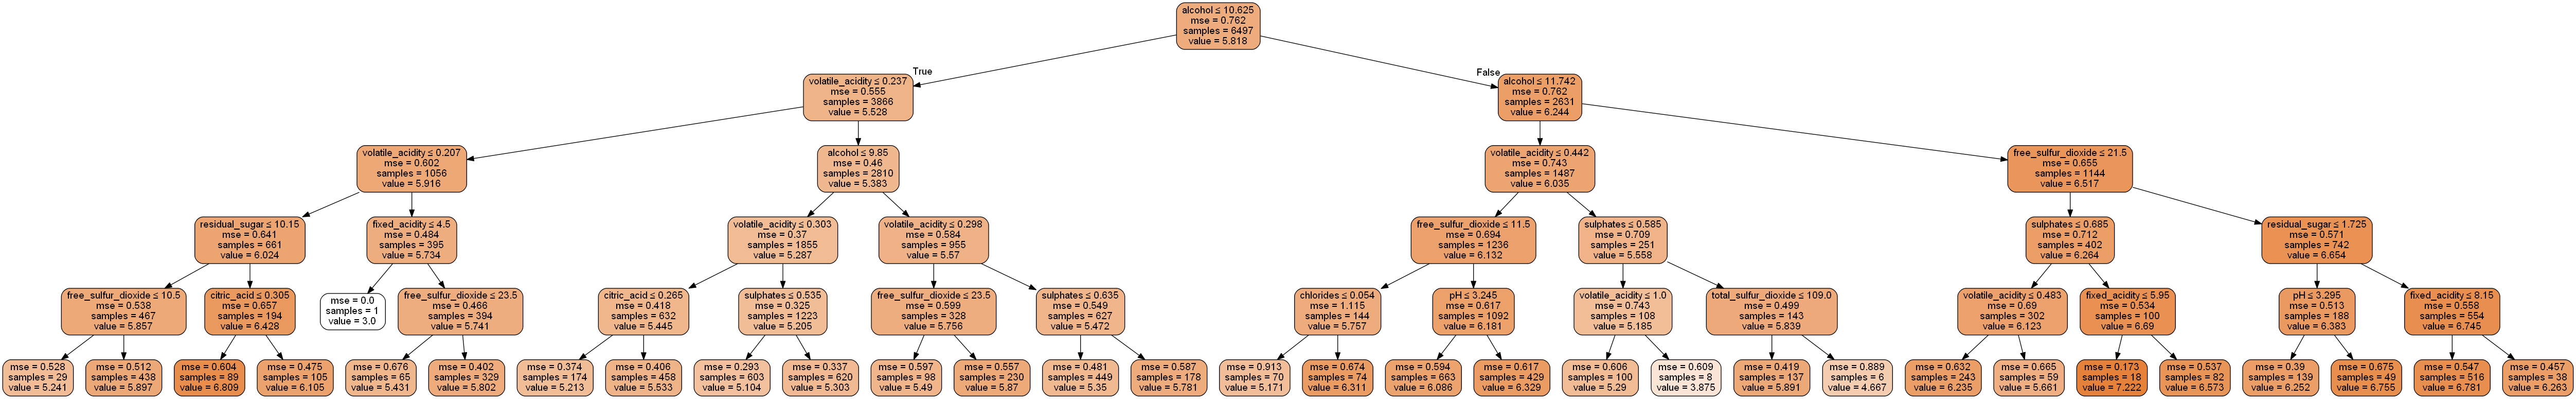

In [31]:
# Plotamos agora a arvore de decisão que retornou os melhores parâmetros
# A arvore parece bastante complexa, mesmo com apenas 5 niveis, para tirarmos conclusões fáceis
# e Infelizmente não foi complexa o suficiente para superar nossa regressão linear simples
dot_data = StringIO()
export_graphviz(dtr,
                out_file=dot_data,  
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names=list(X))
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [65]:
# Vamos começar a usar algoritmos mais complexos para ver se chegamos a resultados melhores.
# Primeiro vamos rodar uma RandomForest que é uma combinação de MUITAS arvores de decisão simples
# E isso permitirá que aumentemos a profundidade de arvore sem causar muito overfiting 
# que é minimizado por utilizarmos uma média de muitas arvores simples

def run_randomforest(depth=1):
    rfr = RandomForestRegressor(n_estimators=100, max_depth=depth)
    return -cross_val_score(rfr,X, y,scoring='neg_mean_squared_error', cv=10)

# Vamos rodar de 1 até 10 niveis de profundidade com crossvalidate
list_metrics=[]
for i in range(1,14,1):
    row=[]
    score = run_randomforest(i)
    row.append(i)
    row.append(score.mean())
    list_metrics.append(row)

In [66]:
pd.DataFrame(list_metrics, columns=['depth','score']).head(11)

depth  score
0       1   0.64
1       2   0.58
2       3   0.56
3       4   0.54
4       5   0.53
5       6   0.52
6       7   0.52
7       8   0.51
8       9   0.51
9      10   0.51
10     11   0.51

In [67]:
metrics

depth  score
0       1   0.55
1       2   0.53
2       3   0.53
3       4   0.55
4       5   0.55
5       6   0.57
6       7   0.58
7       8   0.58
8       9   0.59
9      10   0.60
10     11   0.60
11     12   0.63
12     13   0.65
13     14   0.67

In [68]:
# por último vamos rodar nosso algoritmo mais poderoso, o extreme gradient boosting, ou xgboost.
def run_xgboost(depth=1):
    gbr = XGBRegressor(max_depth=depth,n_estimators=300)
    return -cross_val_score(gbr,X, y, scoring='neg_mean_squared_error', cv=4)

# Vamos rodar de 1 até 10 niveis de profundidade com crossvalidate
list_metrics=[]
for i in range(1,7,1):
    row=[]
    score = run_xgboost(i)
    row.append(i)
    row.append(score.mean())
    list_metrics.append(row)

# Podemos perceber que esse algoritmo não consegue capturar o comportamento apenas com aumento na profundidade
# vamos tentar ir além.
pd.DataFrame(list_metrics, columns=['depth','score'])

depth  score
0      1   0.69
1      2   0.88
2      3   0.95
3      4   0.96
4      5   1.07
5      6   1.08

In [36]:
# Vamos tentar parametrizar ainda melhor nosso algoritmo com um Randomized Search
xgb = XGBRegressor(n_estimators=500)

params = {
        'min_child_weight': [3,5],
        'gamma': [0,0.025],
        'subsample': [.8, .9],
        'colsample_bytree': [0.35, .45],
        'reg_lambda': [8., .9],
        'max_depth': [1,2],
        'base_score':[6]
        }

grid_search = GridSearchCV(xgb,
                           param_grid=params,
                           scoring='neg_mean_squared_error',
                           n_jobs=6,
                           verbose=2)

grid_search.fit(X, y)

print('Best estimator:')
print(grid_search.best_estimator_)
print('\n Best Score:')
print(grid_search.best_score_*-1)
print('\n Best hyperparameters:')
print(grid_search.best_params_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    6.5s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:   20.2s
[Parallel(n_jobs=6)]: Done 192 out of 192 | elapsed:   24.9s finished


Best estimator:
XGBRegressor(base_score=6, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.35, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=1, min_child_weight=3, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=0.9, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9)

 Best Score:
0.739768936739

 Best hyperparameters:
{'base_score': 6, 'colsample_bytree': 0.35, 'gamma': 0, 'max_depth': 1, 'min_child_weight': 3, 'reg_lambda': 0.9, 'subsample': 0.9}


In [64]:
xgb = XGBRegressor(base_score=6,
                   colsample_bytree=.35,
                   gamma=0,
                   max_depth=1,
                   reg_lambda=.9,
                   subsample=.9,
                   min_child_weight=3,
                   n_estimators=500)

%time m1 = -cross_val_score(xgb,X,y,scoring='neg_mean_squared_error', cv=5)
m1.mean()

Wall time: 2.28 s


0.54303609513558748

In [38]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=6, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.35, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=3, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=0.9, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9)

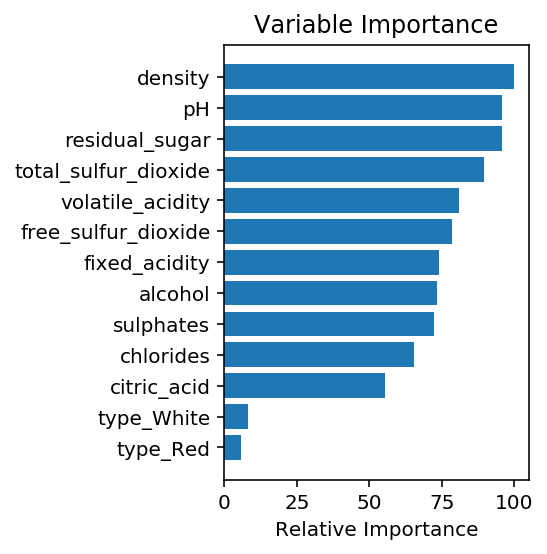

In [40]:
# Então sabemos que temos um modelo bastante poderoso e bem parametrizado para os melhores parâmetros
# Agora vamos começar a entender o que se passa por dentro do modelo.
# Como são centenas de arvores, fica impossivel de plotarmos, mas podemos ver o impacto dessas variáveis.
# Primeiro com o plot importance do próprio modelo:

feature_importance = xgb.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Bonus1 - Usando Teoria dos Jogos para interpretar o modelo criado


## SHAP Values

https://github.com/slundberg/shap

Você viu (e usou) técnicas para extrair insights gerais de um modelo de aprendizado de máquina. Mas e se você quiser detalhar como o modelo funciona para uma previsão individual?

Os valores SHAP (um acrônimo da SHApley Additive exPlanations) dividem uma previsão para mostrar o impacto de cada recurso. Onde você poderia usar isso?


- Um modelo diz que um banco não deve emprestar dinheiro a alguém, e o banco é legalmente obrigado a explicar a base para cada rejeição de empréstimo. 

- Um profissional de saúde deseja identificar quais fatores estão direcionando o risco de alguma doença de cada paciente, para que possam abordar diretamente esses fatores de risco com intervenções de saúde direcionadas.

In [41]:
shap_values = shap.TreeExplainer(xgb).shap_values(X_test)

### Plot importance com shap values

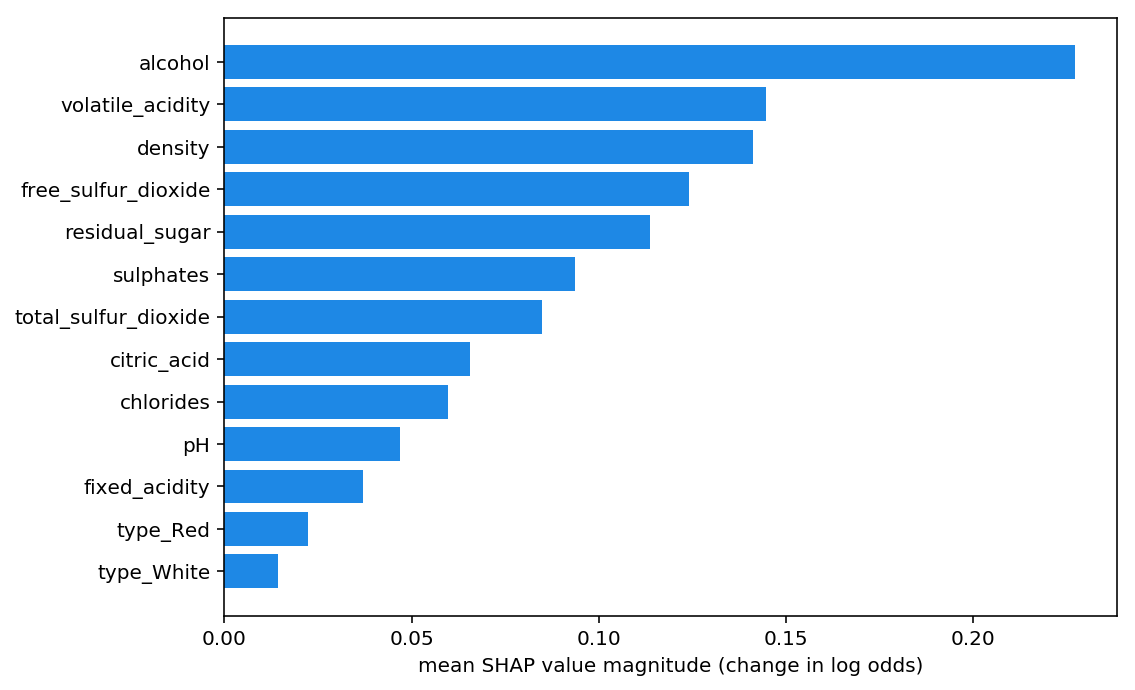

In [42]:
global_shap_vals = np.abs(shap_values).mean(0)[:-1]
variables_values = pd.DataFrame(list(zip(X_test.columns,global_shap_vals)))
variables_values.rename(columns={0:'variable',1:'shap_value'},inplace=True)
variables_values.sort_values(by=['shap_value'],ascending=False,inplace=True)
top_n = variables_values.head(25)

pos=range(0,-top_n.shape[0],-1)
plt.barh(pos, top_n['shap_value'], color="#1E88E5")
plt.yticks(pos, top_n['variable'])
plt.xlabel("mean SHAP value magnitude (change in log odds)")
plt.gcf().set_size_inches(8, 5.5)
plt.gca()
plt.show()

### Resumo dos impactos das variáveis no modelo

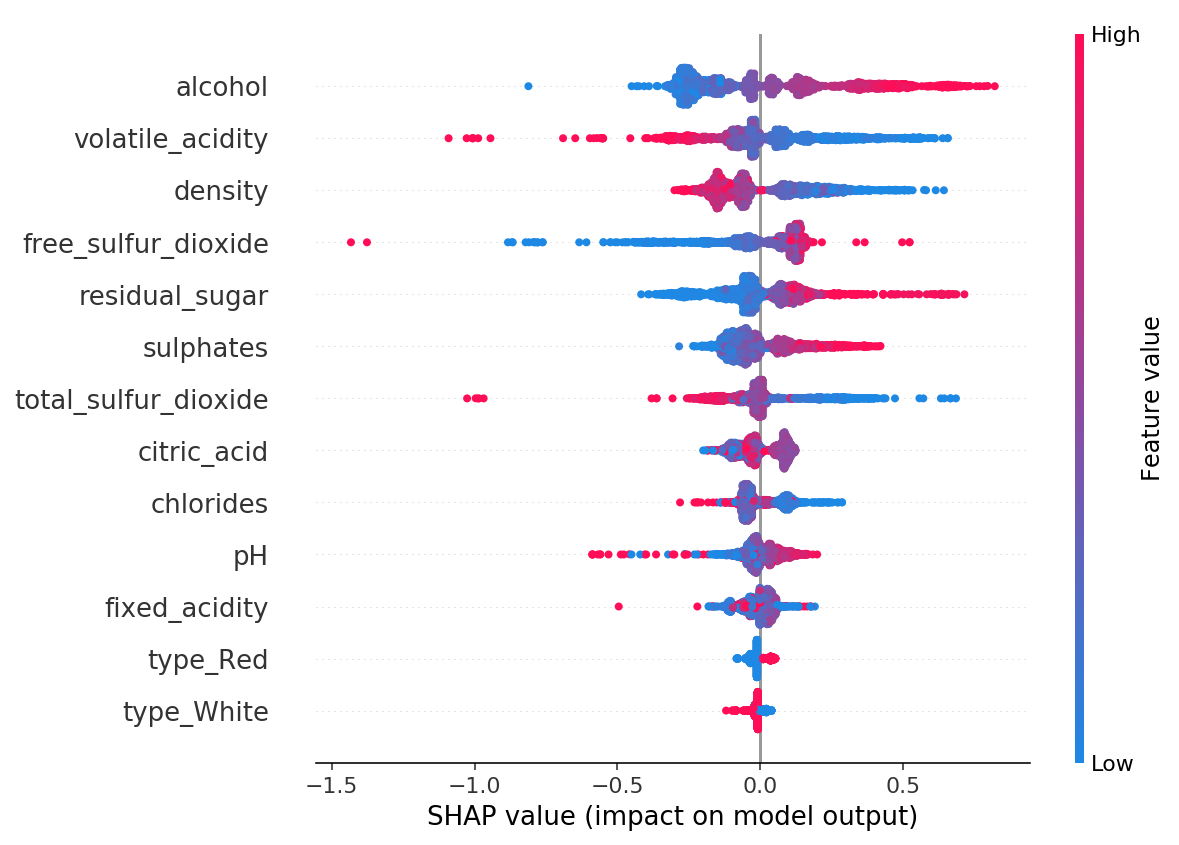

In [43]:
shap.summary_plot(shap_values, X_test)

### Vamos entender agora como o Modelo afeta uma única predição

In [44]:
data_for_prediction

NameError: name 'data_for_prediction' is not defined

In [45]:
row_to_show = 5
data_for_prediction = X_test.iloc[row_to_show]  
# data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

explainer = shap.TreeExplainer(xgb)

shap_values = explainer.shap_values(data_for_prediction)

ValueError: feature_names mismatch: ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'type_Red', 'type_White'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12']
expected alcohol, pH, type_Red, volatile_acidity, residual_sugar, citric_acid, chlorides, type_White, total_sulfur_dioxide, density, sulphates, fixed_acidity, free_sulfur_dioxide in input data
training data did not have the following fields: f11, f3, f10, f5, f4, f2, f1, f12, f6, f0, f9, f8, f7

O objeto shap_values acima é uma lista com duas matrizes. A primeira matriz na lista é os valores de SHAP para um resultado negativo (não ganhe o prêmio). A segunda matriz é a lista de valores SHAP para o resultado positivo, que é como normalmente pensamos em previsões. É complicado revisar uma matriz bruta, mas o pacote shap tem uma boa maneira de visualizar os resultados. 

In [ ]:
# Interpretação: Valores em vermelho aumentam o rating médio e os valores azuis diminuem.
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

E se fizessemos o grafico acima para diversas observações? poderiamos entender por exemplo como o impacto das variáveis "evolui"?

No grafico abaixo fizemos 100 graficos semelhantes ao de cima e viramos 90 graus

In [ ]:
# visualize the training set predictions
shap_values = shap.TreeExplainer(xgb).shap_values(X_test.head(100))
shap.force_plot(explainer.expected_value, shap_values, X_test.head(100))

In [ ]:
shap_values = shap.TreeExplainer(xgb).shap_values(X_test)
shap.dependence_plot("sulphates", shap_values, X_test)

In [ ]:
shap_values = shap.TreeExplainer(xgb).shap_values(X_test)
shap.dependence_plot("volatile_acidity", shap_values, X_test)

# Bonus2 - Criando Modelos combinados para melhor performance

In [49]:
X_train.shape

(4352, 13)

In [51]:
y_train.shape

(4352,)

In [69]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

ensemble = SuperLearner(shuffle=True,
                        array_check = 2,
                        scorer='accuracy_score',
                        verbose=2,
                        n_jobs=2)

# Build the first layer
ensemble.add([RandomForestRegressor(n_estimators=100),
              GradientBoostingRegressor(n_estimators=100),
              XGBRegressor(max_depth=7, n_estimators=100)])

# Build the second layer
# ensemble.add([LogisticRegression(tol=0.00001), SGDClassifier(power_t=0.8)])
# ensemble.add([SGDClassifier(),MLPClassifier(hidden_layer_sizes=100)])

# Attach the final meta estimator
ensemble.add_meta(MLPClassifier(hidden_layer_sizes=5,
                                power_t=0.4,
                                max_iter=300,
                                momentum=0.7))

X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train, y_train, test_size=0.2)
ensemble.fit(X_train_,y_train_)
pred = ensemble.predict(X_test_)


Fitting 2 layers
Processing layer-1             done | 00:00:02
Processing layer-2             done | 00:00:02
Fit complete                        | 00:00:05

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:01


In [70]:
metrics.r2(list(y_test_.values),list(pred))

AttributeError: module 'sklearn.metrics' has no attribute 'r2'

In [63]:
ensemble.scorer(list(y_test_.values),list(pred))

TypeError: 'str' object is not callable